In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
#from sklearn import set_config; set_config(display='diagram')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel, mutual_info_classif

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
filepath="../data/bank-full.csv"
df = pd.read_csv(filepath, sep=';', header=0)
df[df['y'] == 'yes'].head(50)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
83,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
86,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
168,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
270,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
388,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
390,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
446,39,technician,single,unknown,no,45248,yes,no,unknown,6,may,1623,1,-1,0,unknown,yes
457,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes


In [4]:
!pip install statsmodels


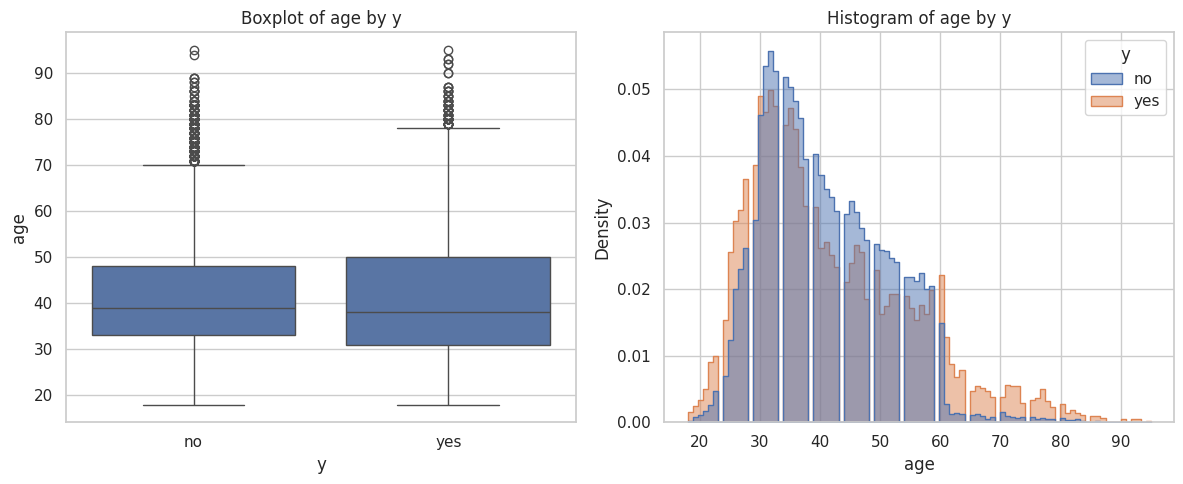

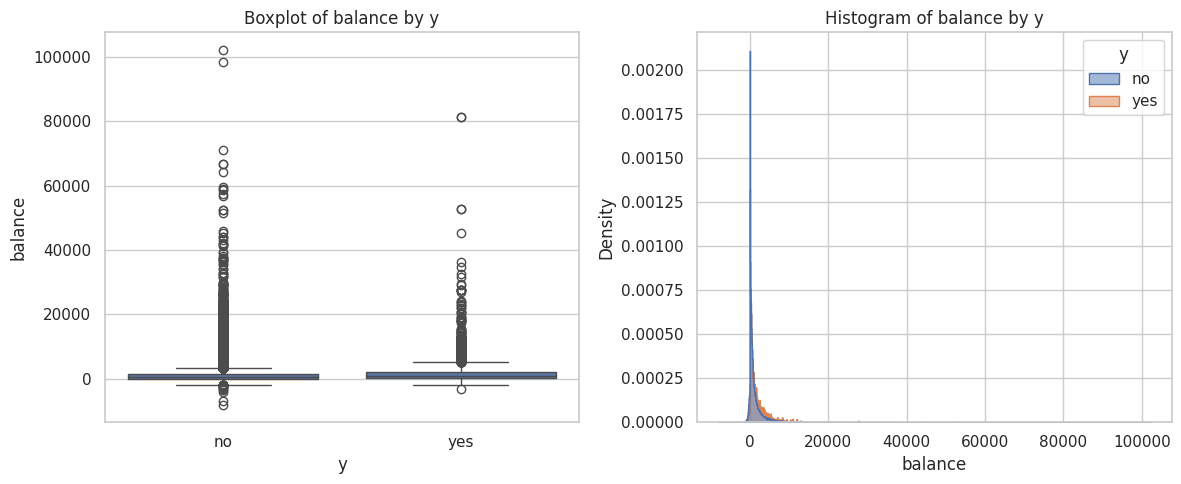

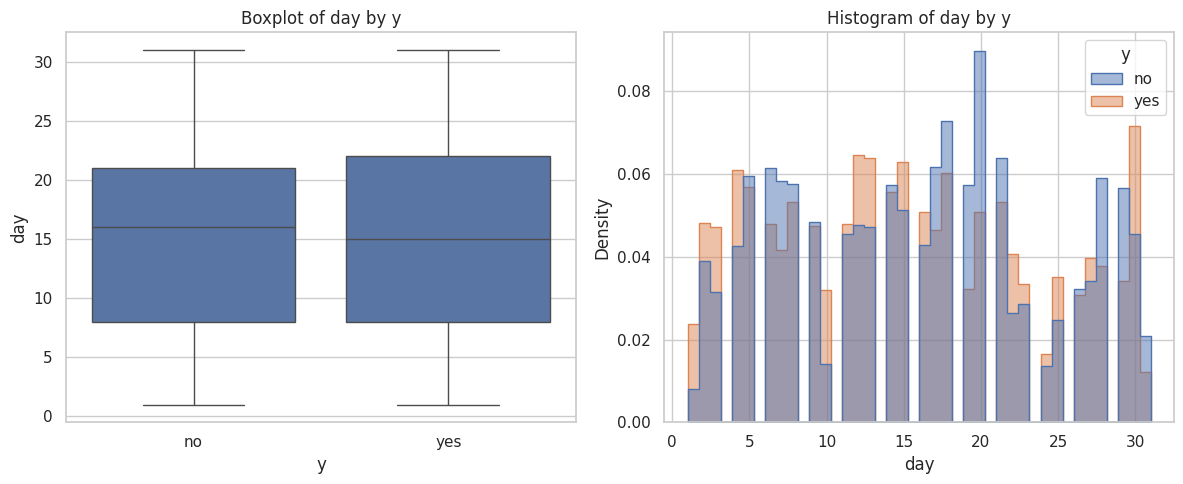

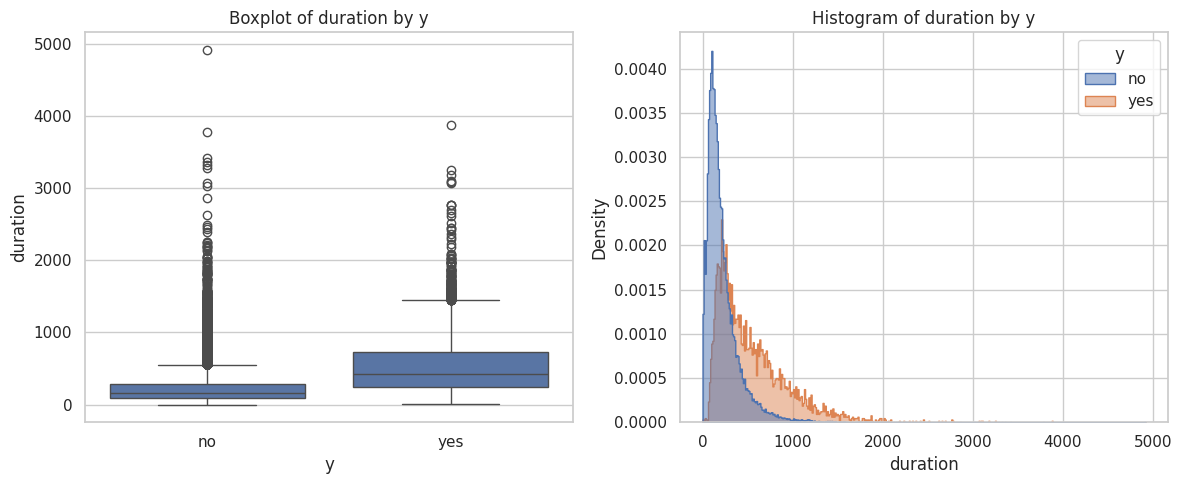

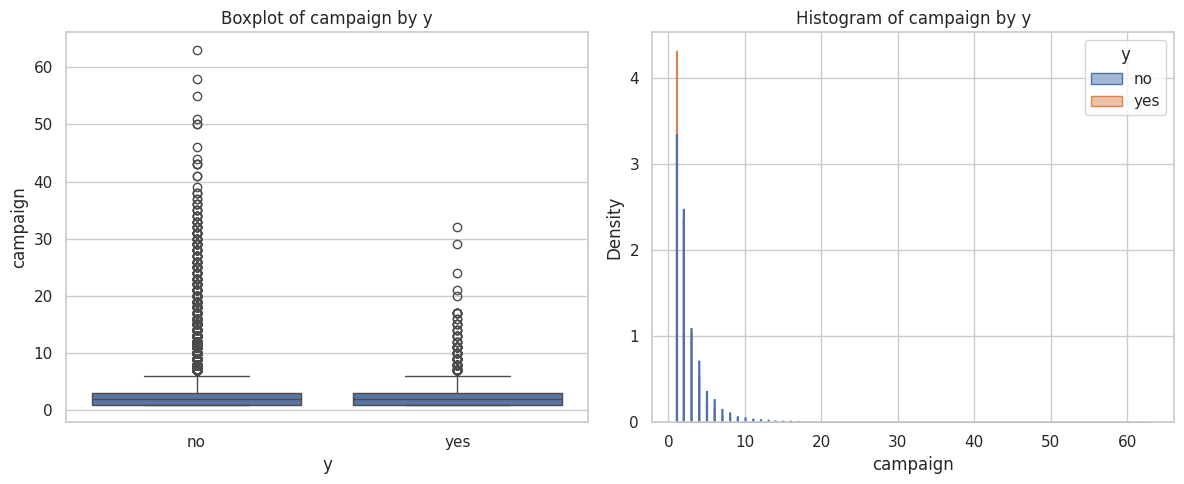

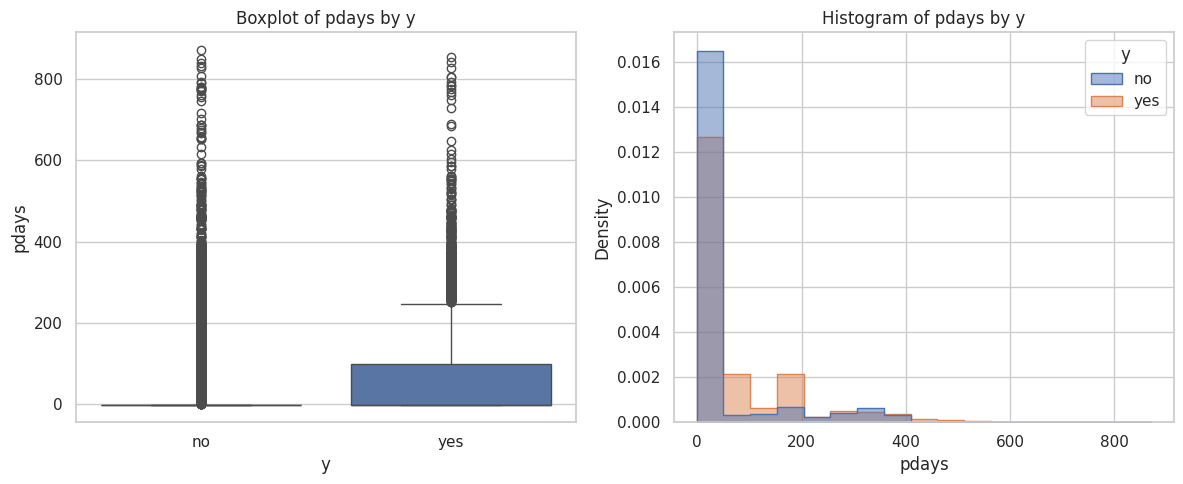

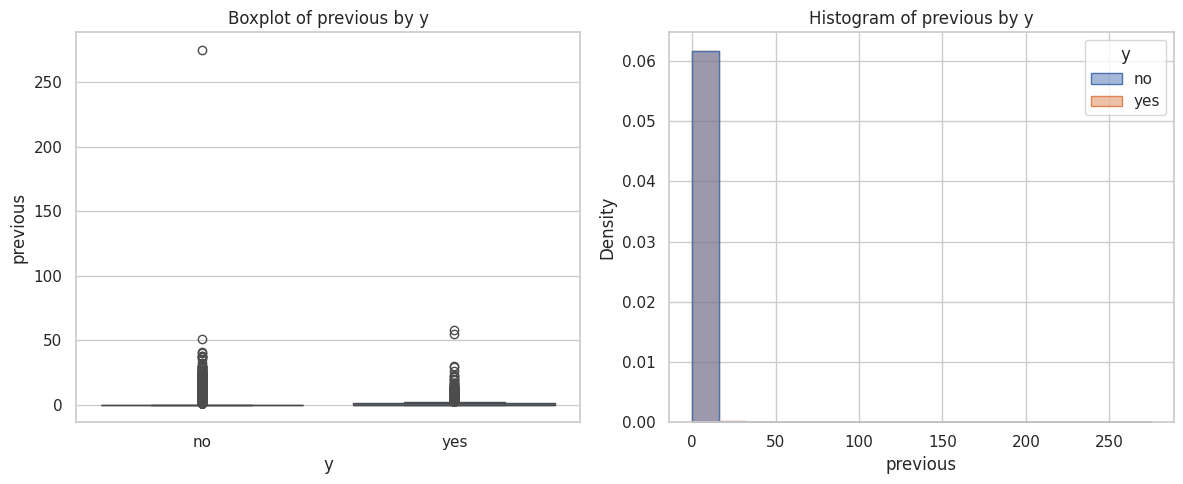

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns to visualize
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Set up plotting style
sns.set(style="whitegrid")

for col in numerical_cols:
    plt.figure(figsize=(12, 5))
    
    # Boxplot split by y
    plt.subplot(1, 2, 1)
    sns.boxplot(x='y', y=col, data=df)
    plt.title(f'Boxplot of {col} by y')
    
    # Histogram split by y (with transparency)
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=col, hue='y', element='step', stat='density', common_norm=False, alpha=0.5)
    plt.title(f'Histogram of {col} by y')
    
    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline  # sklearn's standard pipeline since no SMOTE
import numpy as np
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, classification_report, balanced_accuracy_score
)

# Prepare target and features
y = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])

num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_features = [col for col in X.columns if col not in num_features]

categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Train / val / test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

# Pipeline with preprocessing, feature selection (Lasso), classifier (Logistic Regression)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
        threshold='mean'  # keep features with coefficients above average magnitude
    )),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)

# Evaluate - Accuracy, Recall, Precision, F1
print("=== Train Scores ===")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.3f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.3f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred):.3f}")

print("\n=== Validation Scores ===")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Recall:    {recall_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred):.3f}")

print("\n=== Test Scores ===")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.3f}")

# Detailed classification report for test set
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_test_pred))




=== Train Scores ===
Accuracy:  0.902
Recall:    0.341
Precision: 0.653
F1 Score:  0.448

=== Validation Scores ===
Accuracy:  0.902
Recall:    0.344
Precision: 0.652
F1 Score:  0.450

=== Test Scores ===
Accuracy:  0.901
Recall:    0.339
Precision: 0.645
F1 Score:  0.445

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.64      0.34      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn




In [9]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, recall_score, precision_score, f1_score, classification_report
)
import numpy as np

# Prepare target and features
y = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])

num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_features = [col for col in X.columns if col not in num_features]

categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Train / val / test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

# Pipeline with preprocessing, SMOTE, feature selection, classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(
        LogisticRegression(
            penalty='l1', solver='liblinear', max_iter=2000, C=0.5, random_state=42
        ),
        threshold='mean'
    )),
    ('classifier', LogisticRegression(max_iter=2000, C=0.5, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)


# Evaluate - Accuracy, Recall, Precision, F1, Balanced Accuracy
print("=== Train Scores ===")
print(f"Accuracy:          {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Recall:            {recall_score(y_train, y_train_pred):.3f}")
print(f"Precision:         {precision_score(y_train, y_train_pred):.3f}")
print(f"F1 Score:          {f1_score(y_train, y_train_pred):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_train, y_train_pred):.3f}")

print("\n=== Validation Scores ===")
print(f"Accuracy:          {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Recall:            {recall_score(y_val, y_val_pred):.3f}")
print(f"Precision:         {precision_score(y_val, y_val_pred):.3f}")
print(f"F1 Score:          {f1_score(y_val, y_val_pred):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.3f}")

print("\n=== Test Scores ===")
print(f"Accuracy:          {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Recall:            {recall_score(y_test, y_test_pred):.3f}")
print(f"Precision:         {precision_score(y_test, y_test_pred):.3f}")
print(f"F1 Score:          {f1_score(y_test, y_test_pred):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.3f}")

print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_test_pred))


##SMOTE helps when one group is much smaller than the other. By creating synthetic (fake but realistic) examples for the smaller group, SMOTE balances the data so models can learn better and not get biased toward the larger group.


=== Train Scores ===
Accuracy:          0.847
Recall:            0.799
Precision:         0.420
F1 Score:          0.550
Balanced Accuracy: 0.826

=== Validation Scores ===
Accuracy:          0.846
Recall:            0.803
Precision:         0.417
F1 Score:          0.549
Balanced Accuracy: 0.827

=== Test Scores ===
Accuracy:          0.846
Recall:            0.799
Precision:         0.416
F1 Score:          0.547
Balanced Accuracy: 0.825

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.80      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.90      0.85      0.86      9043



Test ROC AUC: 0.901


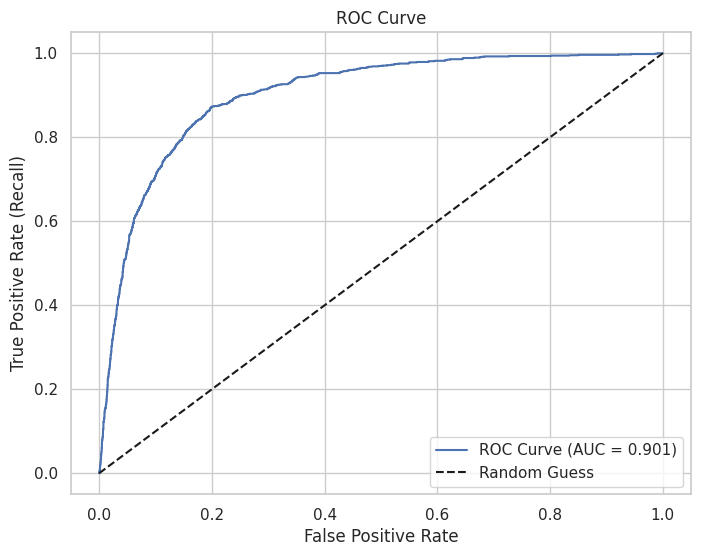

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class (1)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate AUC
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC AUC: {test_auc:.3f}")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
## model's curve staying well above the diagonal and near the top-left corner indicates strong predictive performance.